# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [32]:
data_dir = 'facenet_pytorch/data/CustomTrain'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtain cropped faces.

In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet/facenet_pytorch/models/mtcn

Batch 10 of 16

/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet/facenet_pytorch/models/mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  selected_boxes = np.array(selected_boxes)
/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet/facenet_pytorch/models/mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  selected_points = np.array(selected_points)


Batch 16 of 16

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [7]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

#### Define optimizer, scheduler, dataset, and dataloader

In [33]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

#### Define loss and evaluation functions

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = { 
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

## Train model

In [34]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     3/3    | loss:    0.0005 | fps:  828.0667 | acc:    1.0000   

Epoch 1/8
----------
Train |    12/12   | loss:    0.1347 | fps:  372.3381 | acc:    0.9609   
Valid |     3/3    | loss:    0.9934 | fps: 1033.0707 | acc:    0.7771   

Epoch 2/8
----------
Train |    12/12   | loss:    0.0709 | fps:  375.0671 | acc:    0.9792   
Valid |     3/3    | loss:    1.6478 | fps: 1095.3795 | acc:    0.7028   

Epoch 3/8
----------
Train |    12/12   | loss:    0.0330 | fps:  369.5888 | acc:    0.9870   
Valid |     3/3    | loss:    0.6443 | fps: 1087.5527 | acc:    0.9146   

Epoch 4/8
----------
Train |    12/12   | loss:    0.0490 | fps:  375.0645 | acc:    0.9818   
Valid |     3/3    | loss:    0.1054 | fps: 1082.9178 | acc:    0.9688   

Epoch 5/8
----------
Train |    12/12   | loss:    0.0509 | fps:  371.2674 | acc:    0.9896   
Valid |     3/3    | loss:    0.2503 | fps: 1071.0903 | acc:    0.8729   

Epoch 6/8
----------
Train |    12/12   | loss:    0.0

In [35]:
torch.save(resnet.state_dict(), 'CustomTrained_StateDict.pth')
torch.save(resnet, "CustomTrained.pth")

## Load Model

In [9]:
resnet.load_state_dict(torch.load('CustomTrained_StateDict.pth'))

<All keys matched successfully>

# Inference

In [10]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/val')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [11]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [12]:
faces, classes = next(iter(loader))


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [13]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [14]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999575
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [15]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [22]:
import pandas as pd

dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

              Ishan      Ishan      Janvi      Janvi      Rahul      Rahul  \
Ishan      0.000000   8.014633  28.454613  26.376608  24.847273  29.141624   
Ishan      8.014633   0.000000  21.398407  19.305124  18.292225  22.724724   
Janvi     28.454613  21.398407   0.000000   2.628098  22.155165  25.325819   
Janvi     26.376608  19.305124   2.628098   0.000000  20.649338  24.118029   
Rahul     24.847273  18.292225  22.155165  20.649338   0.000000   5.599203   
Rahul     29.141624  22.724724  25.325819  24.118029   5.599203   0.000000   
Rushiraj  21.440277  15.107408  17.069206  15.482047  14.293674  18.466772   
Rushiraj  22.333164  16.277927  20.451567  19.017860  13.351108  16.843367   
Shakti    22.521097  15.777450  12.081290  10.568524  15.605370  20.492598   
Shakti    26.605022  20.893017  18.047623  17.327953  19.039120  23.629587   
Tirthraj  20.360979  15.932787  21.255812  19.433573  16.775839  21.657375   
Tirthraj  19.358259  14.579584  20.264151  18.271040  16.069973 

## DataLoader based Inference

In [16]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999575
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [15]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print([dataset.idx_to_class[p] for p in preds])

['Ishan', 'Ishan', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi', 'Vidhi']


# Adversarial Attacks

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [57]:
import torch
import numpy as np
import time


class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def pass_epoch(
    model, epsilon, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}

    correct = 0
    adv_examples = []

    for i_batch, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        X.requires_grad = True
        
        y_pred = model(X)
        loss_batch = loss_fn(y_pred, y)

        init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability
        

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            print("INSIDE")
            print(init_pred, y)
            continue
        
        model.zero_grad()
        loss_batch.backward()
        
        data_grad = X.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(X, epsilon, data_grad)
        output = model(perturbed_data)

         # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == y.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(loader), final_acc))

#         if model.training:
#             loss_batch.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#         metrics_batch = {}
#         for metric_name, metric_fn in batch_metrics.items():
#             metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
#             metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            
#         if writer is not None and model.training:
#             if writer.iteration % writer.interval == 0:
#                 writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
#                 for metric_name, metric_batch in metrics_batch.items():
#                     writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
#             writer.iteration += 1
        
#         loss_batch = loss_batch.detach().cpu()
#         loss += loss_batch
#         if show_running:
#             logger(loss, metrics, i_batch)
#         else:
#             logger(loss_batch, metrics_batch, i_batch)
    
#     if model.training and scheduler is not None:
#         scheduler.step()

#     loss = loss / (i_batch + 1)
#     metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
            
#     if writer is not None and not model.training:
#         writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
#         for metric_name, metric in metrics.items():
#             writer.add_scalars(metric_name, {mode: metric})

    #return loss, metrics
    return final_acc, adv_examples


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


In [74]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5, .6, .7, .8, .9, 1.0]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex =  pass_epoch(
        resnet, eps, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    accuracies.append(acc)
    examples.append(ex)
    
writer.close()

Epsilon: 0	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.05	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.1	Test Accuracy = 5 / 94 = 0.05319148936170213
Epsilon: 0.15	Test Accuracy = 12 / 94 = 0.1276595744680851
Epsilon: 0.2	Test Accuracy = 20 / 94 = 0.2127659574468085
Epsilon: 0.25	Test Accuracy = 18 / 94 = 0.19148936170212766
Epsilon: 0.3	Test Accuracy = 17 / 94 = 0.18085106382978725
Epsilon: 0.4	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.5	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.6	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.7	Test Accuracy = 13 / 94 = 0.13829787234042554
Epsilon: 0.8	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.9	Test Accuracy = 5 / 94 = 0.05319148936170213
Epsilon: 1.0	Test Accuracy = 3 / 94 = 0.031914893617021274


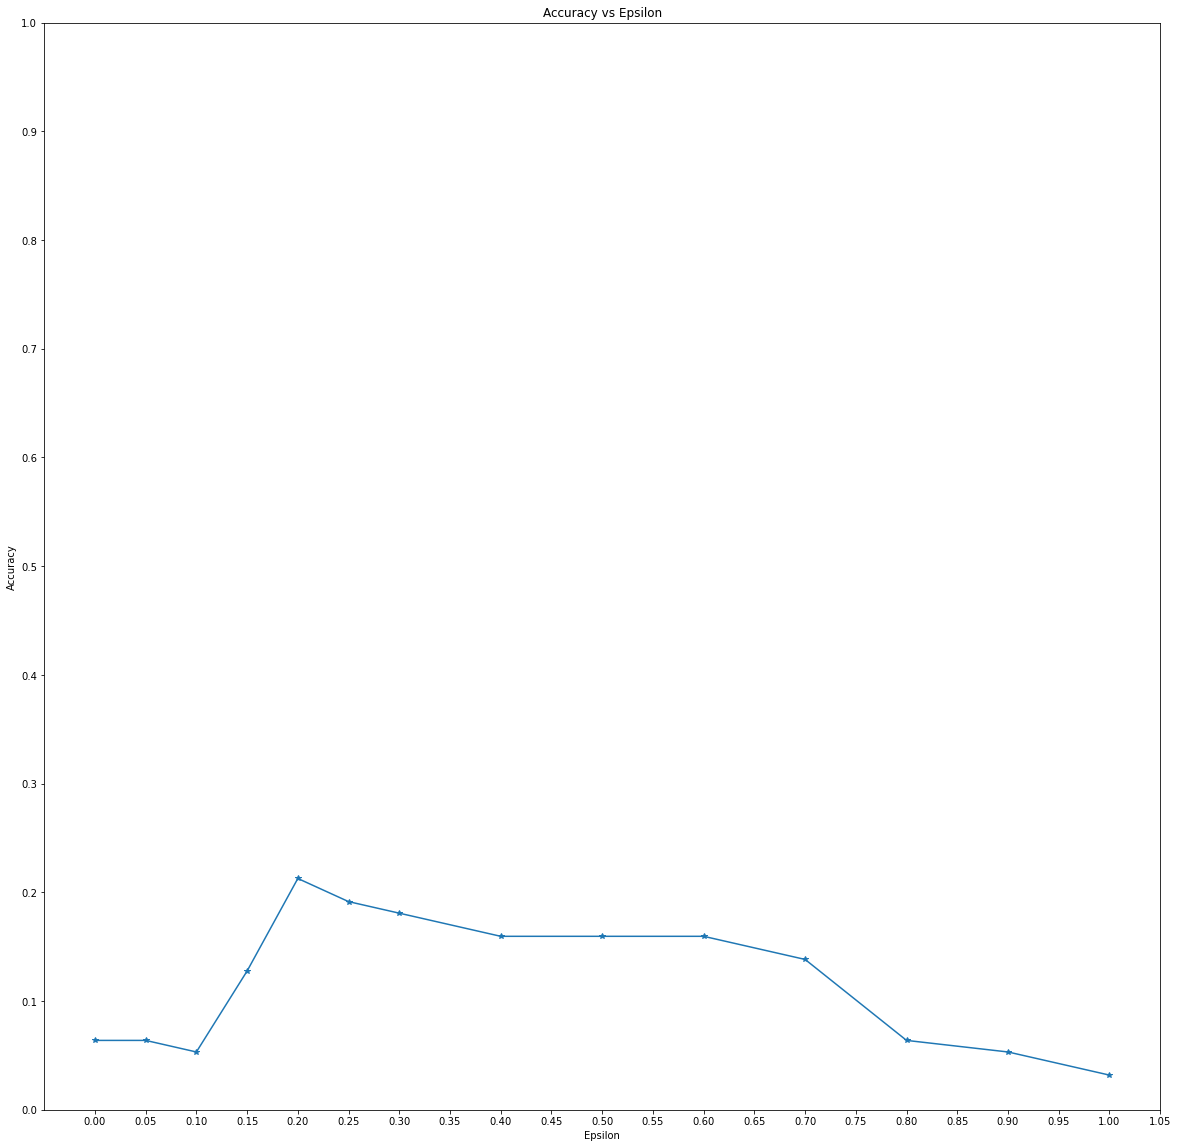

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.plot(epsilons, accuracies, "*-")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("output2.png", dpi = 100, facecolor = 'white')
plt.show()

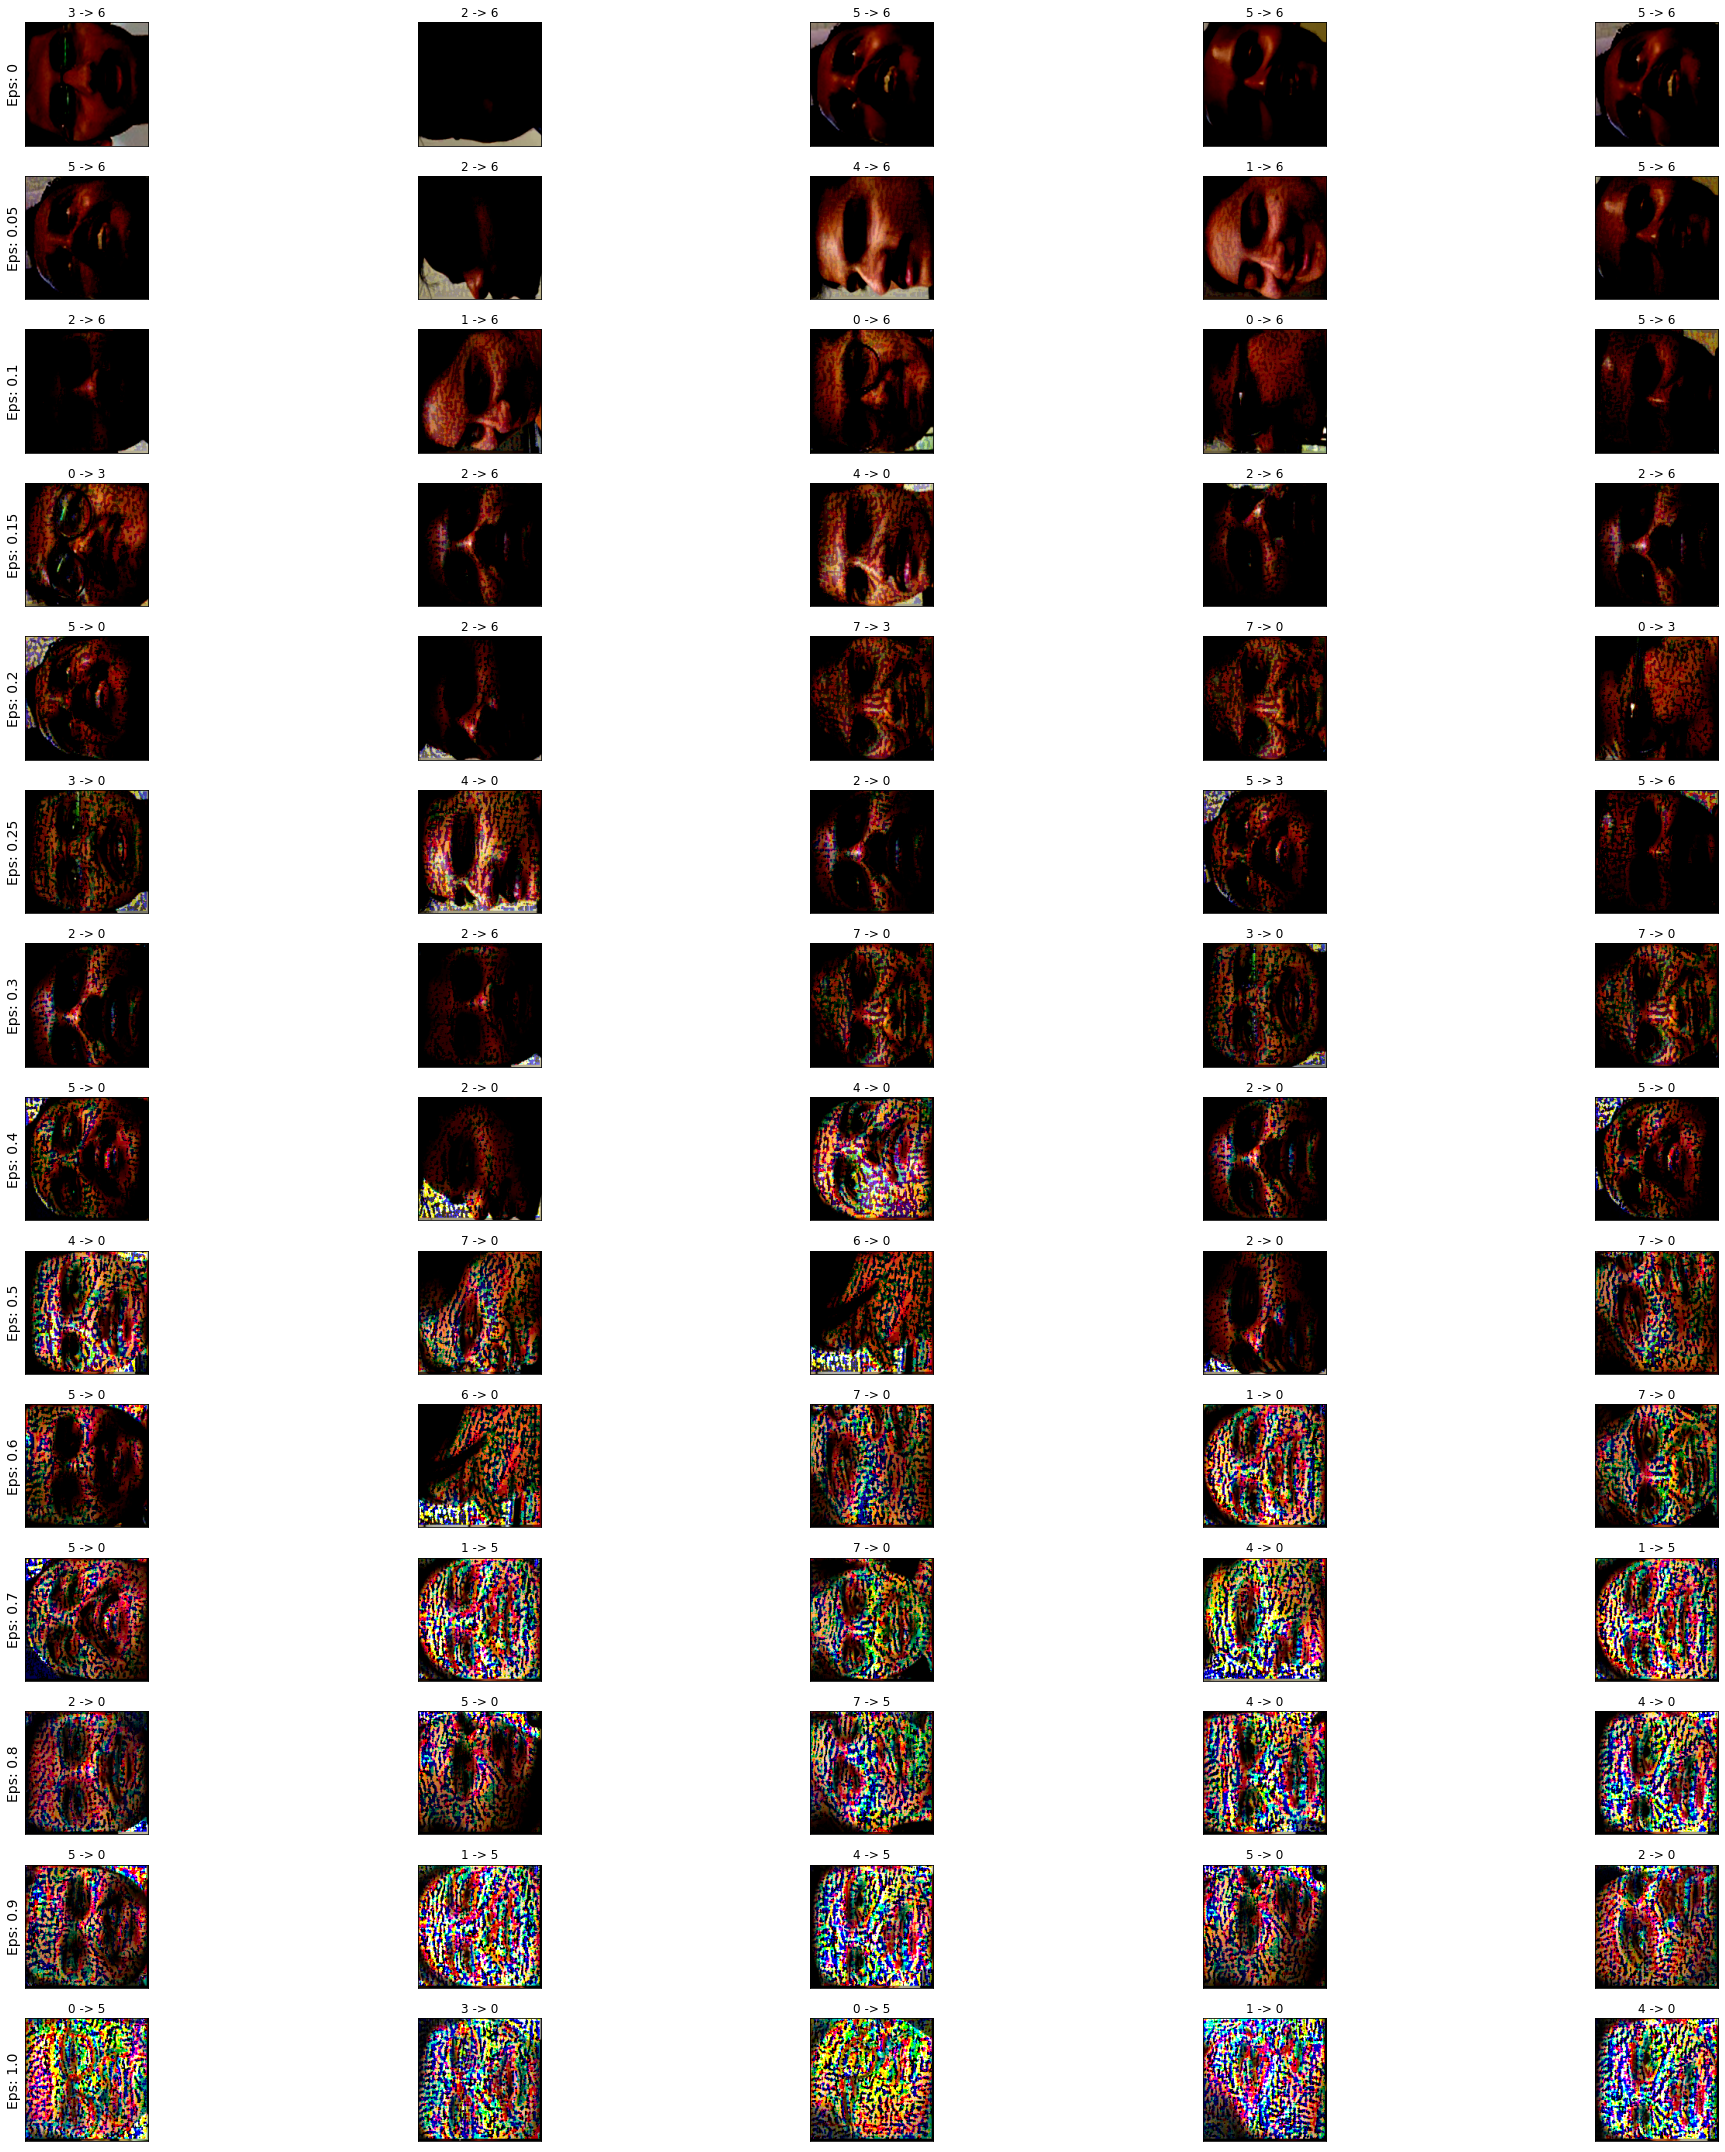

In [85]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(30,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (2, 1, 0)).astype(np.float32)
        plt.imshow(ex, cmap='Blues')
plt.tight_layout()
plt.savefig("Epsilon-Perturbation.png", dpi = 100, facecolor = 'white')
plt.show()